In [1]:

!pip install datasets

from datasets import load_dataset, Dataset


!pip install pandas
!piip install gensim

import pandas as pd

import gensim
from gensim.models import Word2Vec

import numpy as np




     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 542.1/542.1 kB 4.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 4.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.9/64.9 kB 4.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 5.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 5.3 MB/s eta 0:00:00
  Attempting uninstall: requests
    Found existing installation: requests 2.31.0
    Uninstalling requests-2.31.0:
      Successfully uninstalled requests-2.31.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires requests==2.31.0, but you have requests 2.32.3 which is incompatible.
/bin/bash: line 1: piip: command not found


In [2]:
# selecting data from mexican border conflict year
mexican_border_data = load_dataset("dell-research-harvard/AmericanStories",
    "subset_years",
    year_list=["1916"]
)


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/datasets/load.py:1491: FutureWarning: The repository for dell-research-harvard/AmericanStories contains custom code which must be executed to correctly load the dataset. You can inspect the repository content at https://hf.co/datasets/dell-research-harvard/AmericanStories
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this dataset from the 

Only taking a subset of years. Change name to 'all_years' to use all years in the dataset.
{'1916': 'https://huggingface.co/datasets/dell-research-harvard/AmericanStories/resolve/main/faro_1916.tar.gz'}


Generating 1916 split: 0 examples [00:00, ? examples/s]

Loading associated


In [3]:
#converting to a data frame
mexican_border_df = pd.DataFrame.from_dict(mexican_border_data['1916'])



In [4]:
#droppping unneeded rows
mexican_border_df.drop(['newspaper_name','edition','page','headline','byline'], axis=1)

,article_id,date,article
0,1_1916-05-29_p9_sn82014519_00414183062_1916052...,1916-05-29,"Indianapolis, Ind, May 29.-Sheriff Coffin anno..."
1,2_1916-05-29_p9_sn82014519_00414183062_1916052...,1916-05-29,"Ithaca, N. Y, May 29-In the most thrilling rac..."
2,3_1916-05-29_p9_sn82014519_00414183062_1916052...,1916-05-29,In a hard fought game at Walnut Hill park Satu...
3,4_1916-05-29_p9_sn82014519_00414183062_1916052...,1916-05-29,"New York, May 29.-President Bar row of the Int..."
4,6_1916-05-29_p9_sn82014519_00414183062_1916052...,1916-05-29,"Beats Time in To Events.\n\n Ca Ambridge, Mass..."
...,...,...,...
1838792,20_1916-02-10_p1_sn85033000_00414212128_191602...,1916-02-10,"Joe Davidson, Jr., a 1G-year- boy of Mt. Verno..."
1838793,22_1916-02-10_p1_sn85033000_00414212128_191602...,1916-02-10,"Willie Mills, 21, and Alma Robin son, ""A, Gree..."
1838794,26_1916-02-10_p1_sn85033000_00414212128_191602...,1916-02-10,"honorary members of Green Grove lodge No. 107,..."
1838795,29_1916-02-10_p1_sn85033000_00414212128_191602...,1916-02-10,G. D. Allen has bought of w. II. Hooks 40 acre...


In [5]:
#taking a 10% sample of the data to reduce run time
mexican_border_df = mexican_border_df.sample(frac=0.1, random_state=42)

In [6]:
# Tokenize the articles
mexican_border_df['tokenized_article'] = mexican_border_df['article'].apply(gensim.utils.simple_preprocess)

# Train Word2Vec model on the tokenized articles
word2vec_model = Word2Vec(sentences=mexican_border_df['tokenized_article'], vector_size=100, window=5, min_count=2, workers=4)


In [7]:
def encode_article(article):
    tokenized = gensim.utils.simple_preprocess(article)
    vectors = [word2vec_model.wv[word] for word in tokenized if word in word2vec_model.wv]
    if vectors:
        return np.mean(vectors, axis=0)
    else:
        return None

# Encode the articles in batches
batch_size = 10000
encoded_articles = []

for i in range(0, len(mexican_border_df), batch_size):
    batch = mexican_border_df['article'].iloc[i:i + batch_size]
    encoded_batch = batch.apply(encode_article)
    encoded_articles.extend(encoded_batch)

mexican_border_df['encoded_article'] = encoded_articles

# Remove articles that couldn't be encoded
mexican_border_df.dropna(subset=['encoded_article'], inplace=True)


In [8]:
from sklearn.metrics.pairwise import cosine_similarity

racist_keywords = {
    'Mexican': ['greaser', 'wetback', 'beaner', 'pocho'],
    'German': ['kraut', 'hun', 'boche', 'crucco', 'fritz','gummihals','jerry','squarehead','szkop','szwab'],
    'Russian': ['commie', 'red', 'russki','moskal','orc','rosuke','roske','slobo'],
    'Japanese': ['jap', 'nip', 'yellow','brownie','canaca','zip','zipperhead'],
    'Korean': ['gook', 'slope', 'zipperhead','zip']
}

# Encode the racist keywords
encoded_keywords = {ethnicity: [encode_article(word) for word in words if encode_article(word) is not None] for ethnicity, words in racist_keywords.items()}


In [9]:
def calculate_similarity(article_embedding, keywords_embeddings):
    if not keywords_embeddings or article_embedding is None:
        return 0
    similarities = [cosine_similarity([article_embedding], [keyword_embedding])[0][0] for keyword_embedding in keywords_embeddings]
    return max(similarities)

def is_racist(article_embedding, ethnicity, similarity_threshold=0.3):
    keywords_embeddings = encoded_keywords[ethnicity]
    max_similarity = calculate_similarity(article_embedding, keywords_embeddings)
    return 1 if max_similarity > similarity_threshold else 0

# Label each article for each conflict ethnicity in batches
for ethnicity in encoded_keywords.keys():
    batch_results = []
    for i in range(0, len(mexican_border_df), batch_size):
        batch = mexican_border_df['encoded_article'].iloc[i:i + batch_size]
        batch_result = batch.apply(lambda x: is_racist(x, ethnicity))
        batch_results.extend(batch_result)

    mexican_border_df[f'{ethnicity}_racist'] = batch_results


#find average number of racist articles in 1916
mexican_border_df['Mexican_racist'].mean()

#find average number of racists articles in a year when no mexican border conflict

#compare the two averages

#repeat the process with the mexican border with the four other conflicts

#see if there is a trend with all of the different conflicts

#look at the racist language towards other ethnic groups as a control


0.012180712329363848

In [10]:
(mexican_border_df['Mexican_racist']==1).sum()

2237

In [11]:
#repeating process but with korean war and korean people
korean_war_data = load_dataset("dell-research-harvard/AmericanStories",
    "subset_years",
    year_list=["1951"]
)

korean_war_data = pd.DataFrame.from_dict(korean_war_data['1951'])

korean_war_data.drop(['newspaper_name','edition','page','headline','byline'], axis=1)

korean_war_df = korean_war_data.sample(frac=0.3, random_state=42)

# Tokenize the articles
korean_war_df['tokenized_article'] = korean_war_df['article'].apply(gensim.utils.simple_preprocess)

# Train Word2Vec model on the tokenized articles
word2vec_model = Word2Vec(sentences=korean_war_df['tokenized_article'], vector_size=100, window=5, min_count=2, workers=4)

# Encode the articles in batches
batch_size = 10000
encoded_articles = []

for i in range(0, len(korean_war_df), batch_size):
    batch = korean_war_df['article'].iloc[i:i + batch_size]
    encoded_batch = batch.apply(encode_article)
    encoded_articles.extend(encoded_batch)

korean_war_df['encoded_article'] = encoded_articles

# Remove articles that couldn't be encoded
korean_war_df.dropna(subset=['encoded_article'], inplace=True)

for ethnicity in encoded_keywords.keys():
    batch_results = []
    for i in range(0, len(korean_war_df), batch_size):
        batch = korean_war_df['encoded_article'].iloc[i:i + batch_size]
        batch_result = batch.apply(lambda x: is_racist(x, ethnicity))
        batch_results.extend(batch_result)

    korean_war_df[f'{ethnicity}_racist'] = batch_results

/usr/local/lib/python3.10/dist-packages/datasets/load.py:1491: FutureWarning: The repository for dell-research-harvard/AmericanStories contains custom code which must be executed to correctly load the dataset. You can inspect the repository content at https://hf.co/datasets/dell-research-harvard/AmericanStories
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this dataset from the next major release of `datasets`.
  warnings.warn(


Only taking a subset of years. Change name to 'all_years' to use all years in the dataset.
{'1951': 'https://huggingface.co/datasets/dell-research-harvard/AmericanStories/resolve/main/faro_1951.tar.gz'}


Generating 1951 split: 0 examples [00:00, ? examples/s]

Loading associated


In [13]:
(korean_war_df['Russian_racist']==1).mean()

0.01370211413129868

In [14]:
#repeating process but with russian civil war and russian people
russian_war_data = load_dataset("dell-research-harvard/AmericanStories",
    "subset_years",
    year_list=["1918"]
)

russian_war_data = pd.DataFrame.from_dict(russian_war_data['1918'])

russian_war_data.drop(['newspaper_name','edition','page','headline','byline'], axis=1)

russian_war_df = russian_war_data.sample(frac=0.1, random_state=42)

# Tokenize the articles
russian_war_df['tokenized_article'] = russian_war_df['article'].apply(gensim.utils.simple_preprocess)

# Train Word2Vec model on the tokenized articles
word2vec_model = Word2Vec(sentences=russian_war_df['tokenized_article'], vector_size=100, window=5, min_count=2, workers=4)

# Encode the articles in batches
batch_size = 10000
encoded_articles = []

for i in range(0, len(russian_war_df), batch_size):
    batch = russian_war_df['article'].iloc[i:i + batch_size]
    encoded_batch = batch.apply(encode_article)
    encoded_articles.extend(encoded_batch)

russian_war_df['encoded_article'] = encoded_articles

# Remove articles that couldn't be encoded
russian_war_df.dropna(subset=['encoded_article'], inplace=True)

for ethnicity in encoded_keywords.keys():
    batch_results = []
    for i in range(0, len(russian_war_df), batch_size):
        batch = russian_war_df['encoded_article'].iloc[i:i + batch_size]
        batch_result = batch.apply(lambda x: is_racist(x, ethnicity))
        batch_results.extend(batch_result)

    russian_war_df[f'{ethnicity}_racist'] = batch_results

/usr/local/lib/python3.10/dist-packages/datasets/load.py:1491: FutureWarning: The repository for dell-research-harvard/AmericanStories contains custom code which must be executed to correctly load the dataset. You can inspect the repository content at https://hf.co/datasets/dell-research-harvard/AmericanStories
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this dataset from the next major release of `datasets`.
  warnings.warn(


Only taking a subset of years. Change name to 'all_years' to use all years in the dataset.
{'1918': 'https://huggingface.co/datasets/dell-research-harvard/AmericanStories/resolve/main/faro_1918.tar.gz'}


Generating 1918 split: 0 examples [00:00, ? examples/s]

Loading associated


In [15]:
(russian_war_df['Russian_racist']==1).mean()

0.008535377235518015

In [17]:
#repeating process but with ww2 and japanese people
ww2_war_data = load_dataset("dell-research-harvard/AmericanStories",
    "subset_years",
    year_list=["1942"]
)

ww2_war_data = pd.DataFrame.from_dict(ww2_war_data['1942'])

ww2_war_data.drop(['newspaper_name','edition','page','headline','byline'], axis=1)

ww2_war_df = ww2_war_data.sample(frac=0.1, random_state=42)

# Tokenize the articles
ww2_war_df['tokenized_article'] = ww2_war_df['article'].apply(gensim.utils.simple_preprocess)

# Train Word2Vec model on the tokenized articles
word2vec_model = Word2Vec(sentences=ww2_war_df['tokenized_article'], vector_size=100, window=5, min_count=2, workers=4)

# Encode the articles in batches
batch_size = 10000
encoded_articles = []

for i in range(0, len(ww2_war_df), batch_size):
    batch = ww2_war_df['article'].iloc[i:i + batch_size]
    encoded_batch = batch.apply(encode_article)
    encoded_articles.extend(encoded_batch)

ww2_war_df['encoded_article'] = encoded_articles

# Remove articles that couldn't be encoded
ww2_war_df.dropna(subset=['encoded_article'], inplace=True)

for ethnicity in encoded_keywords.keys():
    batch_results = []
    for i in range(0, len(ww2_war_df), batch_size):
        batch = ww2_war_df['encoded_article'].iloc[i:i + batch_size]
        batch_result = batch.apply(lambda x: is_racist(x, ethnicity))
        batch_results.extend(batch_result)

    ww2_war_df[f'{ethnicity}_racist'] = batch_results

In [18]:
(ww2_war_df['Japanese_racist']==1).mean()

0.0432175391020377

In [19]:
#repeating process but with ww1 and German people
ww1_war_data = load_dataset("dell-research-harvard/AmericanStories",
    "subset_years",
    year_list=["1917"]
)

ww1_war_data = pd.DataFrame.from_dict(ww1_war_data['1917'])

ww1_war_data.drop(['newspaper_name','edition','page','headline','byline'], axis=1)

ww1_war_df = russian_war_data.sample(frac=0.1, random_state=42)

# Tokenize the articles
ww1_war_df['tokenized_article'] = ww1_war_df['article'].apply(gensim.utils.simple_preprocess)

# Train Word2Vec model on the tokenized articles
word2vec_model = Word2Vec(sentences=ww1_war_df['tokenized_article'], vector_size=100, window=5, min_count=2, workers=4)

# Encode the articles in batches
batch_size = 10000
encoded_articles = []

for i in range(0, len(ww1_war_df), batch_size):
    batch = ww1_war_df['article'].iloc[i:i + batch_size]
    encoded_batch = batch.apply(encode_article)
    encoded_articles.extend(encoded_batch)

ww1_war_df['encoded_article'] = encoded_articles

# Remove articles that couldn't be encoded
ww1_war_df.dropna(subset=['encoded_article'], inplace=True)

for ethnicity in encoded_keywords.keys():
    batch_results = []
    for i in range(0, len(ww1_war_df), batch_size):
        batch = ww1_war_df['encoded_article'].iloc[i:i + batch_size]
        batch_result = batch.apply(lambda x: is_racist(x, ethnicity))
        batch_results.extend(batch_result)

    ww1_war_df[f'{ethnicity}_racist'] = batch_results

/usr/local/lib/python3.10/dist-packages/datasets/load.py:1491: FutureWarning: The repository for dell-research-harvard/AmericanStories contains custom code which must be executed to correctly load the dataset. You can inspect the repository content at https://hf.co/datasets/dell-research-harvard/AmericanStories
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this dataset from the next major release of `datasets`.
  warnings.warn(


Only taking a subset of years. Change name to 'all_years' to use all years in the dataset.
{'1917': 'https://huggingface.co/datasets/dell-research-harvard/AmericanStories/resolve/main/faro_1917.tar.gz'}


Generating 1917 split: 0 examples [00:00, ? examples/s]

Loading associated


In [20]:
(ww1_war_df['German_racist']==1).mean()

0.03086709421763387

In [21]:
mexican_proportion = (mexican_border_df['Mexican_racist']).mean()
korean_proportion = (korean_war_df['Russian_racist']==1).mean()
german_proportion = (ww1_war_df['German_racist']==1).mean()
russian_proportion = (russian_war_df['Russian_racist']==1).mean()
japanese_proportion = (ww2_war_df['Japanese_racist']==1).mean()


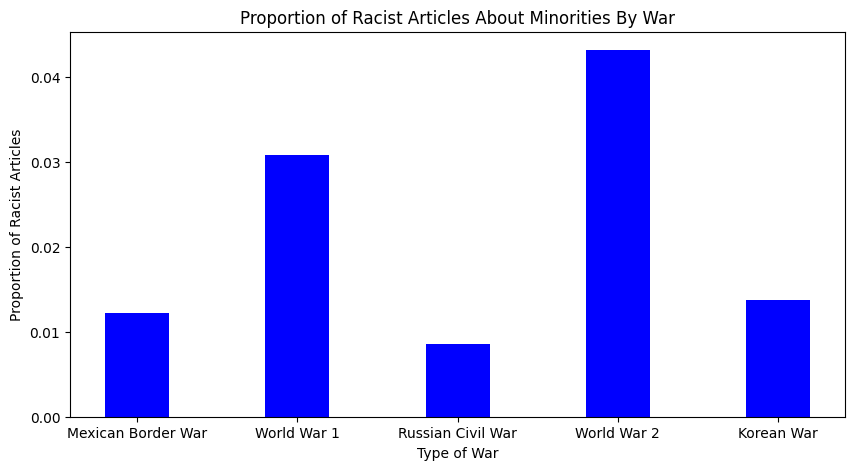

In [22]:
#making a bar plot comparing the racist language between the different wars

import matplotlib.pyplot as plt

# creating the dataset
data = {'Mexican Border War':mexican_proportion, 'World War 1':german_proportion, 'Russian Civil War':russian_proportion,
        'World War 2':japanese_proportion, 'Korean War':korean_proportion}
courses = list(data.keys())
values = list(data.values())

fig = plt.figure(figsize = (10, 5))

# creating the bar plot
plt.bar(courses, values, color ='blue',
        width = 0.4)

plt.xlabel("Type of War")
plt.ylabel("Proportion of Racist Articles")
plt.title("Proportion of Racist Articles About Minorities By War")
plt.show()